# CIFO Project

In [1]:
import sys
import os

# Add the full path to CIFO_PROJECT to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from copy import deepcopy
import random
from random import sample, shuffle
from statistics import stdev
import pandas as pd
from typing import List, Tuple


In [2]:
import importlib.util
import sys
import os

# Load solution.py as a module named 'library.solution'
module_path = os.path.abspath("../library/solution.py")
spec = importlib.util.spec_from_file_location("library.solution", module_path)
solution = importlib.util.module_from_spec(spec)
sys.modules["library.solution"] = solution
spec.loader.exec_module(solution)

# Now the import works
from library.solution import Solution
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm

In [3]:
#import players from csv

players = pd.read_csv('../data/players.csv')
print(players)

    Unnamed: 0              Name Position  Skill  Salary (€M)
0            0       Alex Carter       GK     85           90
1            1      Jordan Smith       GK     88          100
2            2     Ryan Mitchell       GK     83           85
3            3    Chris Thompson       GK     80           80
4            4   Blake Henderson       GK     87           95
5            5     Daniel Foster      DEF     90          110
6            6     Lucas Bennett      DEF     85           90
7            7       Owen Parker      DEF     88          100
8            8      Ethan Howard      DEF     80           70
9            9        Mason Reed      DEF     82           75
10          10      Logan Brooks      DEF     86           95
11          11      Caleb Fisher      DEF     84           85
12          12     Nathan Wright      MID     92          120
13          13      Connor Hayes      MID     89          105
14          14      Dylan Morgan      MID     91          115
15      

In [4]:
players.shape

(35, 5)

In [5]:
NAMES = players['Name'].tolist()
POSITIONS = players['Position'].tolist()
SKILLS = players['Skill'].tolist()
SALARIES = players['Salary (€M)'].tolist()

CAPACITY = 750
NUM_TEAMS=5
TEAM_SIZE=7

## Sports League Optimization Solution

In [6]:
#Creating the Solution for Sports League Optimization (SLO)
from library.solution import Solution
"""Problem definition
Problem: Sports League Optimization (SLO)
Search space: All possible assignments of 35 players into 5 teams, each with 7 players (non-overlapping). Each team must be composed of: 1GK, 2DEF, 2MID, 2FWD.
Representation: List of 5 teams each one with a list of 7 players.
Fitness function: f(x)= standard deviation of the average skill rating of the teams.
Neighborhood: Swap two players with the same position between two teams.
Goal: Minimize f(x).
"""

class SLOSolution(Solution):

    def __init__(
            self,
            names: list[str]=NAMES,
            positions : list[str]=POSITIONS,
            skills : list[int]=SKILLS,
            salaries : list[int]=SALARIES,
            capacity: int = CAPACITY,
            repr=None
    ):
        self.names = names
        self.positions = positions
        self.skills = skills
        self.salaries = salaries
        self.num_teams = NUM_TEAMS
        self.team_size = TEAM_SIZE
        self.capacity = capacity

        # Grouping players by position
        self.players_by_position = {
            'GK': [i for i, position in enumerate(self.positions) if position == 'GK'],
            'DEF': [i for i, position in enumerate(self.positions) if position == 'DEF'],
            'MID': [i for i, position in enumerate(self.positions) if position == 'MID'],
            'FWD': [i for i, position in enumerate(self.positions) if position == 'FWD'],
        }


        if repr:
            repr = self._validate_repr(repr)

        super().__init__(repr = repr)


    #MAYBE A BETER VALIDATE FUNCTION IS NEEDED
    #--------------------------------------------------------
    def _validate_repr(self,repr):
        # Check if the representation is a list of teams
        if not isinstance(repr, list):
            raise ValueError("Representation must be a list of teams")
        #check if the number of teams is correct
        if len(repr) != self.num_teams:
            raise ValueError("Number of teams must be equal to num_teams")
        #check if each team has the correct number of players
        for team in repr:
            if not isinstance(team, list):
                raise ValueError("Each team must be a list of players")
            if len(team) != self.team_size:
                raise ValueError("Each team must have 7 players")
            

        #check if team is valid (1GK, 2DEF, 2 MID, 2FWD)
        seen_players = set()

        for i, team in enumerate(repr):
            team_positions = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
            team_salary = 0

            seen_players = set()
            for player_idx in team:
                # Check that the player hasn't already been assigned
                if player_idx in seen_players:
                    raise ValueError(f"Player {player_idx} assigned to multiple teams")
                seen_players.add(player_idx)

                pos = self.positions[player_idx]
                sal = self.salaries[player_idx] # TO BE CONFIRMED

                if pos not in team_positions:
                    raise ValueError(f"Invalid position; '{pos}', for player {player_idx}")
                team_positions[pos] += 1 
                team_salary += sal # TO BE CONFIRMED

            
            if team_positions != {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2}:
                raise ValueError(f"Team {i} has invalid composition: {team_positions}")
            
            # TO BE CONFIRMED
            #if team_salary > self.capacity:
                #raise ValueError(f"Team {i} exceeds salary cap: {team_salary:.2f}M > {self.capacity}M")
        return repr
        
    
    def random_initial_representation(self):
        isValid = False

        while not isValid:
            try:
                repr = []
                used_players = set()

                for _ in range(self.num_teams):
                    team = []
                    gk = random.choice([p for p in self.players_by_position['GK'] if p not in used_players])
                    used_players.add(gk)
                    team.append(gk)

                    def_players = random.sample([p for p in self.players_by_position['DEF'] if p not in used_players], 2)
                    used_players.update(def_players)
                    team.extend(def_players)

                    mid_players = random.sample([p for p in self.players_by_position['MID'] if p not in used_players], 2)
                    used_players.update(mid_players)
                    team.extend(mid_players)

                    fwd_players = random.sample([p for p in self.players_by_position['FWD'] if p not in used_players], 2)
                    used_players.update(fwd_players)
                    team.extend(fwd_players)

                    repr.append(team)

                repr = self._validate_repr(repr)
                isValid = True

            except (ValueError, IndexError) as e:
                print(f"Invalid representation: {e}")
                isValid = False

        return repr

                    
    def fitness(self):

        team_avg_skill=[]

        for team in self.repr:
            team_salary = sum(self.salaries[player_idx] for player_idx in team)
            if team_salary > self.capacity:
                return 999

            team_skills=[self.skills[player_idx] for player_idx in team]
            avg_skill=sum(team_skills)/len(team_skills)
            team_avg_skill.append(avg_skill)
        
        return stdev(team_avg_skill)

In [7]:
#create a team to test the code
slo_solution = SLOSolution(
    names=NAMES, 
    positions=POSITIONS, 
    skills=SKILLS, 
    salaries=SALARIES, 
    capacity=CAPACITY, 
    repr=None
)

random_teams = slo_solution.random_initial_representation()
print("Random teams:") 
for i, team in enumerate(random_teams):
    print(f"Team {i+1}: {[NAMES[player_idx] for player_idx in team]}")
    #check fitness of the repr
print(f"Fitness: {slo_solution.fitness()}") #TO BE CONFIRMED

Random teams:
Team 1: ['Blake Henderson', 'Caleb Fisher', 'Lucas Bennett', 'Ashton Phillips', 'Dylan Morgan', 'Chase Murphy', 'Julian Scott']
Team 2: ['Jordan Smith', 'Owen Parker', 'Maxwell Flores', 'Dominic Bell', 'Bentley Rivera', 'Xavier Bryant', 'Landon Powell']
Team 3: ['Alex Carter', 'Daniel Foster', 'Mason Reed', 'Gavin Richardson', 'Connor Hayes', 'Adrian Collins', 'Sebastian Perry']
Team 4: ['Chris Thompson', 'Jaxon Griffin', 'Ethan Howard', 'Nathan Wright', 'Austin Torres', 'Tyler Jenkins', 'Zachary Nelson']
Team 5: ['Ryan Mitchell', 'Brayden Hughes', 'Logan Brooks', 'Hunter Cooper', 'Spencer Ward', 'Elijah Sanders', 'Colton Gray']
Fitness: 1.5952736314449878


## Mutation Functions

In [8]:
def mutation1(solution, mutation_probability=0.5):
    repr = solution.repr
    position = random.choice(['GK', 'DEF', 'MID', 'FWD'])

    mutated_repr = deepcopy(repr)

    for i in range(5):
        if random.random() <= mutation_probability:
            from_team = i
            to_team = (i + 1) % 5

            # Dynamically extract current position players (up-to-date)
            from_candidates = [p for p in mutated_repr[from_team] if solution.positions[p] == position]
            to_candidates = [p for p in mutated_repr[to_team] if solution.positions[p] == position]

            if not from_candidates or not to_candidates:
                continue

            player_from = random.choice(from_candidates)
            player_to = random.choice(to_candidates)

            # Swap the players
            mutated_repr[from_team][mutated_repr[from_team].index(player_from)] = player_to
            mutated_repr[to_team][mutated_repr[to_team].index(player_to)] = player_from

    return mutated_repr

In [9]:
def mutation2(solution, mutation_probability=0.7):
        # Choose a random player from the first team
        repr = solution.repr
        first_team = repr[0]
        player_idx = random.choice(first_team)
        position = POSITIONS[player_idx]

        mutated_repr = deepcopy(repr)
        current_player_idx = player_idx

        if random.random() <= mutation_probability:
            for i in range(solution.num_teams):
                next_team = (i + 1) % solution.num_teams

                # Pick a random player from the next team with the same position
                next_team_position_players = [p for p in mutated_repr[next_team] if POSITIONS[p] == position]
                if not next_team_position_players:
                    continue

                next_player_idx = random.choice(next_team_position_players)

                # Perform the swap
                mutated_repr[i][mutated_repr[i].index(current_player_idx)] = next_player_idx
                current_player_idx = next_player_idx

        # Validate and update the representation
        #repr = self._validate_repr(mutated_repr)

        return repr

In [10]:
def mutation3(solution, mutation_probability=0.5):
    repr = solution.repr  

    if random.random() > mutation_probability:
        return repr

    mutated_repr = deepcopy(repr)

    for _ in range(10):  # Máximo de 10 tentativas para encontrar uma mutação válida
        team_a_idx, team_b_idx = random.sample(range(NUM_TEAMS), 2)
        team_a = mutated_repr[team_a_idx]
        team_b = mutated_repr[team_b_idx]

        position = random.choice(['GK', 'DEF', 'MID', 'FWD'])

        pos_players_a = [p for p in team_a if solution.positions[p] == position]
        pos_players_b = [p for p in team_b if solution.positions[p] == position]

        if not pos_players_a or not pos_players_b:
            continue

        player_a = random.choice(pos_players_a)
        player_b = random.choice(pos_players_b)

        new_team_a = team_a.copy()
        new_team_b = team_b.copy()
        new_team_a[new_team_a.index(player_a)] = player_b
        new_team_b[new_team_b.index(player_b)] = player_a

        def is_valid(team):
            role_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
            total_salary = 0
            for p in team:
                role_count[solution.positions[p]] += 1
                total_salary += solution.salaries[p]
            return role_count == {'GK': 1, 'DEF': 2, 'MID': 2, 'FWD': 2} and total_salary <= solution.capacity

        if is_valid(new_team_a) and is_valid(new_team_b):
            mutated_repr[team_a_idx] = new_team_a
            mutated_repr[team_b_idx] = new_team_b
            return mutated_repr  #return the mutated version

    return repr  # If no valid mutation found, return original


## Crossover Functions

In [11]:
CHROMO_LEN  = TEAM_SIZE * NUM_TEAMS     # 35 genes  (unique player IDs)
def _flatten(repr_: List[List[int]]) -> List[int]:
    return [player for team in repr_ for player in team]

def _unflatten(flat: List[int]) -> List[List[int]]:
    return [flat[i:i+TEAM_SIZE] for i in range(0, CHROMO_LEN, TEAM_SIZE)]


def cycle_crossover(p1: List[List[int]],
                    p2: List[List[int]],
                    rng: random.Random | None = None
                   ) -> Tuple[List[List[int]], List[List[int]]]:
   
    if rng is None:
        rng = random

    # flatten the parents
    parent1 = _flatten(p1)
    parent2 = _flatten(p2)

    # mapping gene ➜ index for O(1) look-ups in parent1
    idx_in_p1 = {gene: idx for idx, gene in enumerate(parent1)}

    size     = CHROMO_LEN
    visited  = [False] * size
    child1   = [None]  * size
    child2   = [None]  * size
    cycle_no = 0

    while not all(visited):
        start = visited.index(False)          # first unvisited position
        idx   = start
        cycle = []

        # trace one cycle
        while True:
            cycle.append(idx)
            visited[idx] = True
            gene_from_p2 = parent2[idx]
            idx = idx_in_p1[gene_from_p2]     # where that gene sits in P1
            if visited[idx]:
                break

        # copy genes
        if cycle_no % 2 == 0:                 # even-numbered cycle
            for i in cycle:
                child1[i] = parent1[i]
                child2[i] = parent2[i]
        else:                                 # odd-numbered cycle
            for i in cycle:
                child1[i] = parent2[i]
                child2[i] = parent1[i]

        cycle_no += 1

    # rebuild the 5 teams and return
    return _unflatten(child1), _unflatten(child2)


In [12]:
# create two random parents 
p1 = slo_solution.random_initial_representation()
p2 = slo_solution.random_initial_representation()

# crossover 
childA_repr, childB_repr = cycle_crossover(p1, p2)

# validate & compute fitness
childA = SLOSolution(repr=childA_repr)
childB = SLOSolution(repr=childB_repr)

print("Child-A fitness:", childA.fitness())
print("Child-B fitness:", childB.fitness())


Child-A fitness: 999
Child-B fitness: 999


In [13]:
def pmxo(p1: List[List[int]], p2: List[List[int]]) -> Tuple[List[List[int]], List[List[int]]]:
    parent1 = _flatten(p1)
    parent2 = _flatten(p2)
    n = len(parent1)

    c1, c2 = sorted(random.sample(range(n), 2))
    child1, child2 = [-1]*n, [-1]*n

    # 1) Copy crossover segments
    child1[c1:c2+1] = parent2[c1:c2+1]
    child2[c1:c2+1] = parent1[c1:c2+1]

    def fill(child, donor, seg):
        mapping = {seg[i]: donor[i] for i in range(c1, c2+1)}
        for i in range(n):
            if not (c1 <= i <= c2):
                gene = donor[i]
                while gene in child:
                    gene = mapping[gene]
                child[i] = gene
        return child

    child1 = fill(child1, parent1, parent2)
    child2 = fill(child2, parent2, parent1)

    return _unflatten(child1), _unflatten(child2)


## Selection Functions

In [14]:
def tournament_selection(population, k=3):

    # Select a random subset of the population for the tournament
    tournament_solutions = random.sample(population, k)

    best = min(tournament_solutions, key=lambda ind: ind.fitness())

    return deepcopy(best)

In [15]:
def fitness_proportionate_selection(population, maximization=False):
    # similar to the one made in class

    fitness_values = [1 / ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    random_nr = random.uniform(0, total_fitness)

    boundary = 0
    for ind_idx, ind in enumerate(population):
        boundary += fitness_values[ind_idx]
        if random_nr <= boundary:
            return deepcopy(ind)

## SLO Genetic Algorithm Solution

In [16]:
class SLOGASolution(SLOSolution):
    def __init__(
        self,
        names,
        positions,
        skills,
        salaries,
        capacity,
        mutation_function,
        crossover_function,
        repr=None,
    ):
        self.mutation_function = mutation_function
        self.crossover_function = crossover_function
        self.selection_function = fitness_proportionate_selection

        super().__init__(
            names=names,
            positions=positions,
            skills=skills,
            salaries=salaries,
            capacity=capacity,
            repr=repr,
        )

    def mutation(self, mut_prob=0.5):

        new_repr = self.mutation_function(self, mut_prob)
        new_solution = SLOGASolution(
            names=self.names,
            positions=self.positions,
            skills=self.skills,
            salaries=self.salaries,
            capacity=self.capacity,
            mutation_function=self.mutation_function,
            crossover_function=self.crossover_function,
            repr=new_repr
        )
        return new_solution
    
    def crossover(self, other):

        parent1 = self.repr
        parent2 = other.repr

        child1_repr, child2_repr = self.crossover_function(parent1, parent2)
        child1 = SLOGASolution(
            names=self.names,
            positions=self.positions,
            skills=self.skills,
            salaries=self.salaries,
            capacity=self.capacity,
            mutation_function=self.mutation_function,
            crossover_function=self.crossover_function,
            repr=child1_repr
        )
        child2 = SLOGASolution(
            names=self.names,
            positions=self.positions,
            skills=self.skills,
            salaries=self.salaries,
            capacity=self.capacity,
            mutation_function=self.mutation_function,
            crossover_function=self.crossover_function,
            repr=child2_repr
        )
        return child1, child2
    
        

In [17]:
#applying the genetic algorithm
POP_SIZE = 100

intial_population = [
    SLOGASolution(
        names=NAMES,
        positions=POSITIONS,
        skills=SKILLS,
        salaries=SALARIES,
        capacity=CAPACITY,
        mutation_function=mutation2,
        crossover_function=cycle_crossover
    ) for _ in range(POP_SIZE)
]

best_solution = genetic_algorithm(
    initial_population=intial_population,
    max_gen=100,
    selection_algorithm=fitness_proportionate_selection,
    maximization=False,
    xo_prob=0.8,
    mut_prob=0.5,
    elitism=True,
    verbose=False,
)

print("Best solution found:", best_solution)
#print("Fitness:", best_solution.fitness())

Best solution found: ([[1, 30, 9, 31, 14, 23, 19], [4, 7, 28, 18, 13, 25, 24], [3, 11, 10, 29, 12, 20, 34], [0, 8, 5, 15, 16, 21, 26], [2, 33, 6, 17, 27, 32, 22]], [0.36977654587270725, 0.35571141708538767, 0.3410667538946623, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.119522860933435

## Grid Search

In [18]:
import itertools


POP_SIZE = 100
GENERATIONS = 100

grid_params = {
    "crossover": [
        {
            "function": cycle_crossover,
            "xo_prob": 0.8
        },
        {
            "function": pmxo,
            "xo_prob": 0.8
        }
    ],
    "mutation": [

        {
            "function": mutation1,
            "mut_prob": 0.5
        },
        {
            "function": mutation2, 
            "mut_prob": 0.5
        },
        {
            "function": mutation3,
            "mut_prob": 0.2
        }
    ],
    "elitism": [True, False]
}

fitness_dfs = {}
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

for crossover_cfg, mutation_cfg, elitism in grid:
    df = pd.DataFrame(columns=range(GENERATIONS))

    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]

    config_results = []

    for run_nr in range(5):
        initial_population = [
            SLOGASolution(
                capacity=CAPACITY,
                names=NAMES,
                positions=POSITIONS,
                salaries=SALARIES,
                skills=SKILLS,
                mutation_function=mutation_function,
                crossover_function=crossover_function,
            ) for _ in range(POP_SIZE)
        ]

        _, fitness_over_gens = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=fitness_proportionate_selection,
            maximization=False,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=elitism,
            verbose=False
        )

        config_results.append(fitness_over_gens)
        df.loc[run_nr] = fitness_over_gens

    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_elitism={elitism}"
    )

    fitness_dfs[config_label] = df


In [19]:
from matplotlib import pyplot as plt


def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

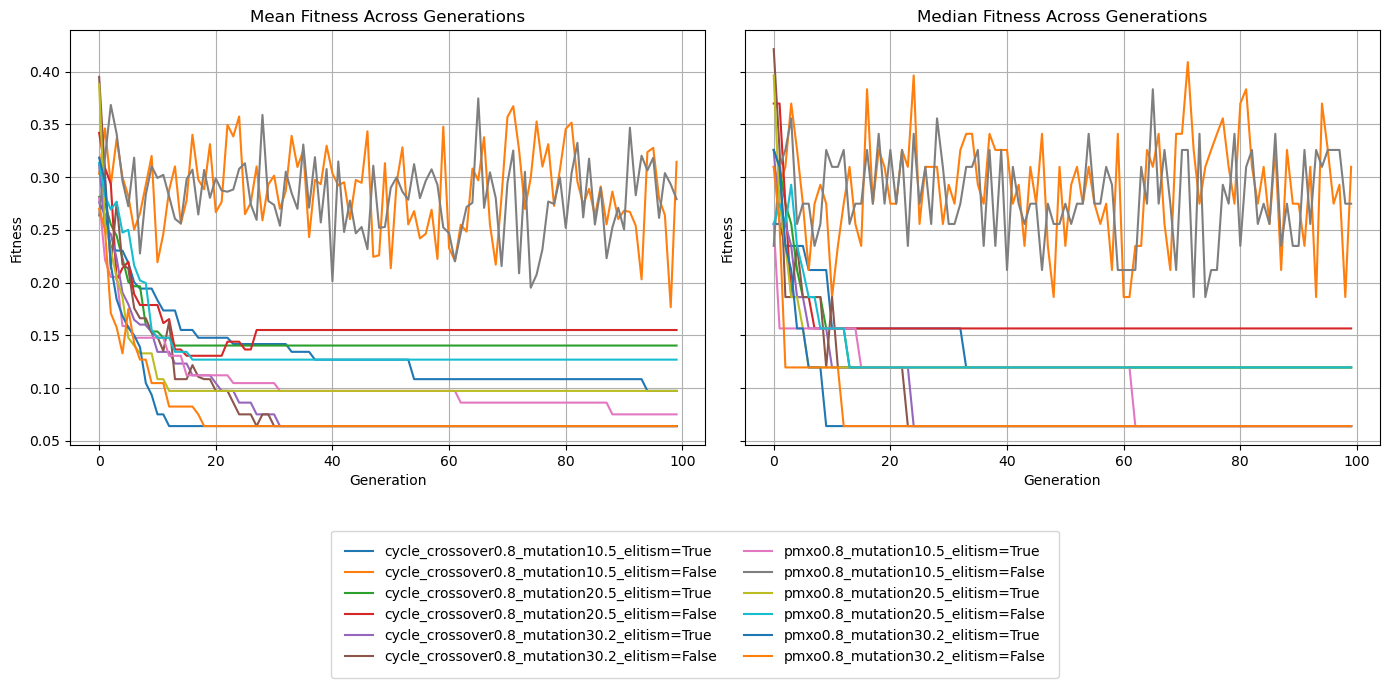

In [20]:
plot_fitness_over_gen(fitness_dfs)